# Main code

## 實驗目的與目標（Toy Model：3D Gaussian Mixture Diffusion）

- **建立一個最小可行的 3D diffusion 架構**  
  利用簡化的三維點雲（兩團 Gaussian mixture），驗證 diffusion model 在 3D 空間中能否正確學習 denoising 與 score function。

- **測試 SE(3)-equivariant 架構的有效性**  
  使用簡化版 EGNN 作為 score network，確認模型在旋轉與平移變換下仍能保持一致的預測。

- **驗證 DSM（Denoising Score Matching）訓練是否能收斂**  
  測試模型是否能學到  
  $$
  s_\theta(x_t,t) \approx -\epsilon / \sigma_t
  $$  
  並逐步降低 score error。

- **評估 reverse diffusion 的生成能力**  
  從純高斯噪聲開始，逐步反向取樣，觀察模型是否能重建接近  
  $$
  0.5\,\mathcal{N}(\mu_1,I) + 0.5\,\mathcal{N}(\mu_2,I)
  $$  
  的三維點雲結構。

- **作為進階 3D 分子生成的前置練習**  
  為後續延伸到 QM9 分子生成、化學 constraints、或更複雜的蛋白質骨架 diffusion 打下基礎。


## Algorithm 1. Toy Model：3D Gaussian Mixture Diffusion Training & Sampling

**Input:**  
- Two Gaussian centers $ \mu_1, \mu_2 \in \mathbb{R}^3 $  
- Diffusion schedule $\{\bar\alpha_t, \sigma_t\}_{t=1}^T$  
- Score network $s_\theta(\cdot, t)$ (EGNN-based)  
- Number of training samples $N$  
- Learning rate $\eta$

---

### **Step 1. Generate Training Data**
1. For $i = 1,\dots,N$:
   1. Sample mixture component $k \in \{1,2\}$ with probability $0.5$.
   2. Sample  
      $$
      x_0^{(i)} \sim \mathcal{N}(\mu_k, I).
      $$

---

### **Step 2. Forward Diffusion (Data Noising)**
For each $x_0^{(i)}$:

1. Uniformly sample a timestep  
   $$
   t \sim \text{Uniform}\{1,\dots,T\}.
   $$

2. Sample noise  
   $$
   \epsilon \sim \mathcal{N}(0,I).
   $$

3. Generate perturbed sample  
   $$
   x_t = \sqrt{\bar\alpha_t}\, x_0 + \sigma_t \epsilon.
   $$

---

### **Step 3. Train Score Network via DSM**
For each mini-batch:

1. Compute model prediction  
   $$
   \hat{s} = s_\theta(x_t, t).
   $$

2. Compute DSM loss  
   $$
   L_{\text{DSM}}
   = \mathbb{E}\left[
      \|\,\hat{s} + \epsilon / \sigma_t \|^2
     \right].
   $$

3. Update parameters  
   $$
   \theta \leftarrow \theta - \eta \nabla_\theta L_{\text{DSM}}.
   $$

Repeat until convergence.

---

### **Step 4. Reverse Diffusion Sampling**
To generate new 3D point clouds:

1. Initialize  
   $$
   x_T \sim \mathcal{N}(0,I).
   $$

2. For $t = T, T-1,\dots,1$:

   1. Predict score  
      $$
      \hat{s}_t = s_\theta(x_t, t).
      $$

   2. Sample noise $z \sim \mathcal{N}(0,I)$ (except at $t=1$)

   3. Update  
      $$
      x_{t-1}
      = x_t
      + \beta_t\, \hat{s}_t
      + \sqrt{\beta_t}\, z.
      $$

3. Output final sample $x_0$ as generated 3D point cloud.

---

### **Output:**  
Generated 3D point clouds approximating the original mixture  
$$
0.5\,\mathcal{N}(\mu_1, I) + 0.5\,\mathcal{N}(\mu_2, I).
$$


---

# Code
## Settings

In [2]:
import math
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

T = 1000  # number of diffusion steps

beta_start = 1e-4
beta_end   = 2e-2
betas = torch.linspace(beta_start, beta_end, T, device=device)   # (T,)
alphas = 1.0 - betas                                             # (T,)
alpha_bar = torch.cumprod(alphas, dim=0)                         # (T,)

# In the forward formula x_t = sqrt(alpha_bar_t) x_0 + sigma_t eps
sigmas = torch.sqrt(1.0 - alpha_bar)                             # (T,)

# -------------------------------------------
import matplotlib.pyplot as plt

def plot_loss_curve(loss_list):
    """
    loss_list: Python list or Tensor containing loss values for each step
    """
    plt.figure(figsize=(8,4))
    plt.plot(loss_list, linewidth=1.5)
    plt.xlabel("Training step")
    plt.ylabel("Loss (DSM)")
    plt.title("DSM Training Loss Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [3]:
### Data: 3D Gaussian mixture
mu1 = torch.tensor([+2.0, 0.0, 0.0], device=device)
mu2 = torch.tensor([-2.0, 0.0, 0.0], device=device)

N_POINTS = 64   # 每個點雲的點數

def sample_x0_cloud(batch_size: int, n_points: int = N_POINTS) -> torch.Tensor:
    """
    回傳 shape = (B, N, 3)
    每個點 independently 來自 0.5 N(mu1, I) + 0.5 N(mu2, I)
    """
    B = batch_size
    mix = torch.bernoulli(0.5 * torch.ones(B, n_points, device=device))  # (B,N)
    mu = torch.where(mix.unsqueeze(-1) == 1, mu1, mu2)                  # (B,N,3)
    eps = torch.randn(B, n_points, 3, device=device)
    x0 = mu + eps
    return x0

### Time embdding
class FourierTimeEmbedding(nn.Module):
    def __init__(self, dim: int = 64, max_freq: float = 1000.0):
        super().__init__()
        self.dim = dim
        self.freqs = torch.exp(
            torch.linspace(0, math.log(max_freq), dim // 2)
        )

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """
        t: (B,) in [0, T-1]
        回傳: (B, dim)
        """
        t_norm = t.float() / float(T)
        freqs = self.freqs.to(t.device)
        args = t_norm.unsqueeze(-1) * freqs  # (B, dim/2)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return emb


## Score Neuralnet

In [ ]:
\class EGNNLayer(nn.Module):
    def __init__(self, time_dim: int = 64, hidden_dim: int = 64):
        super().__init__()
        self.time_dim = time_dim
        in_dim = 1 + time_dim  # r^2 + t_emb

        self.edge_mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 1)   # scalar weight for each edge
        )

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor) -> torch.Tensor:
        """
        x:     (B, N, 3)
        t_emb: (B, time_dim)
        回傳:  (B, N, 3)
        """
        B, N, _ = x.shape

        # pairwise differences & distances
        diff = x.unsqueeze(2) - x.unsqueeze(1)         # (B, N, N, 3)
        r2 = (diff ** 2).sum(dim=-1, keepdim=True)     # (B, N, N, 1)

        # broadcast time embedding到 edge
        te = t_emb.unsqueeze(1).unsqueeze(2).expand(B, N, N, -1)  # (B,N,N,time_dim)

        h_edge = torch.cat([r2, te], dim=-1)           # (B,N,N,1+time_dim)
        w_ij = self.edge_mlp(h_edge)                   # (B,N,N,1)

        # coordinate update: sum_j w_ij * (x_i - x_j)
        dx = (w_ij * diff).sum(dim=2)                  # (B,N,3)
        x_out = x + dx
        return x_out

class EGNNScoreNet(nn.Module):
    def __init__(self, n_layers: int = 3, time_dim: int = 64, hidden_dim: int = 64):
        super().__init__()
        self.t_emb = FourierTimeEmbedding(dim=time_dim)
        self.layers = nn.ModuleList([
            EGNNLayer(time_dim=time_dim, hidden_dim=hidden_dim)
            for _ in range(n_layers)
        ])
        self.out_mlp = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, x_t: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        x_t: (B, N, 3)
        t:   (B,)
        回傳: score (B, N, 3)
        """
        t_emb = self.t_emb(t)   # (B,time_dim)

        x = x_t
        for layer in self.layers:
            x = layer(x, t_emb)

        # 最終用 MLP 產生 score（每個點一個 3D 向量）
        B, N, _ = x.shape
        x_flat = x.reshape(B * N, 3)
        s_flat = self.out_mlp(x_flat)
        s = s_flat.reshape(B, N, 3)
        return s

model = EGNNScoreNet().to(device)


In [5]:
#### DSM Loss

def dsm_loss_egnn(model: nn.Module, batch_size: int) -> torch.Tensor:
    """
    DSM: E[ || s_theta(x_t,t) + eps/sigma_t ||^2 ] over all points
    """
    x0 = sample_x0_cloud(batch_size)          # (B,N,3)

    # sample timestep
    t = torch.randint(0, T, (batch_size,), device=device)
    # （可選）bias t 到大噪聲區：例如 t = (t.float()**1.5 / T).long().clamp(max=T-1)

    alpha_bar_t = alpha_bar[t].view(-1, 1, 1) # (B,1,1)
    sigma_t     = sigmas[t].view(-1, 1, 1)    # (B,1,1)

    eps = torch.randn_like(x0)                # (B,N,3)
    x_t = torch.sqrt(alpha_bar_t) * x0 + sigma_t * eps

    s_hat = model(x_t, t)                     # (B,N,3)

    target = -eps / sigma_t                   # (B,N,3)
    loss = torch.mean((s_hat - target) ** 2)
    return loss

In [6]:
#### Training loop
batch_size = 64
lr = 2e-4
num_steps = 20_000

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=200,
    cooldown=100,
    min_lr=1e-6
)

loss_history = []

model.train()
for step in range(1, num_steps + 1):
    loss = dsm_loss_egnn(model, batch_size)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    loss_history.append(loss.item())

    if step % 200 == 0:
        print(f"step {step:5d} | loss={loss.item():.4f} | lr={optimizer.param_groups[0]['lr']:.6e}")


step   200 | loss=nan | lr=2.000000e-04


KeyboardInterrupt: 

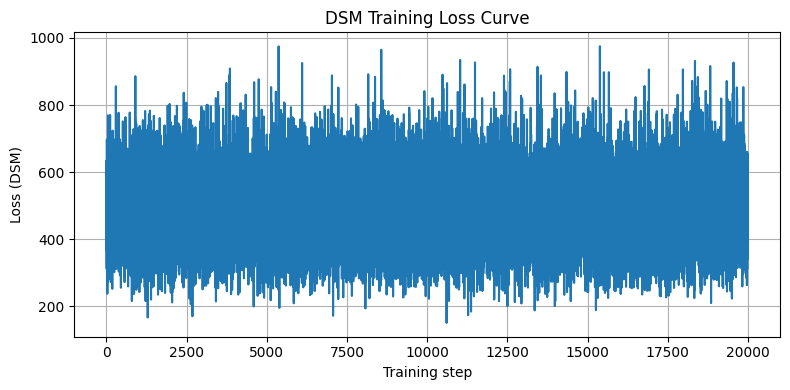

In [33]:
plot_loss_curve(loss_history)

## Reverse diffussion sampling

In [8]:
@torch.no_grad()
def sample(model: nn.Module, num_samples: int) -> torch.Tensor:
    """
    Run reverse diffusion to generate samples.
    Returns: (num_samples, 3)
    """
    model.eval()
    # start from pure Gaussian noise
    x_t = torch.randn(num_samples, 3, device=device)

    for t_inv in range(T - 1, -1, -1):
        t = torch.full((num_samples,), t_inv, device=device, dtype=torch.long)

        beta_t   = betas[t_inv]            # scalar
        alpha_t  = alphas[t_inv]
        sqrt_alpha_t = torch.sqrt(alpha_t)
        # diffusion-style update (simple Euler discretization)
        s_hat = model(x_t, t)              # (B,3)

        # here we use a simple VE-style update: x_{t-1} = x_t + beta_t s + sqrt(beta_t) z
        z = torch.randn_like(x_t) if t_inv > 0 else torch.zeros_like(x_t)
        x_t = x_t + beta_t * s_hat + torch.sqrt(beta_t) * z

    return x_t  # interpreted as x_0

In [9]:
samples = sample(model, num_samples=10_000)  # (10000, 3)
